In [45]:
!pip install torch torchvision

Error: nu::shell::xdg_config_home_invalid

  × $env.XDG_CONFIG_HOME (=/Users/luca/.config) is invalid, using default
  │ config directory instead: /Users/luca/Library/Application Support/nushell
  help: Set XDG_CONFIG_HOME to an absolute path, or set it to an empty string
        to ignore it

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Aufgabe 1

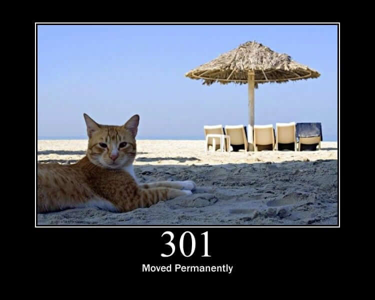

(600, 750, 3)
uint8
R mean: 78.41 std: 82.65
G mean: 84.17 std: 89.20
B mean: 95.78 std: 104.15


In [37]:
import numpy as np
import torch
from PIL import Image

with Image.open("301.jpg") as im:
    display(im.resize((375,300)))

    arr = np.asarray(im)
    print(arr.shape)
    print(arr.dtype)

    tensor = torch.tensor(arr)
    tensor = tensor.to(torch.float32)
    
    print(f"R mean: {tensor[:, :, 0].mean():.2f} std: {tensor[:, :, 0].std():.2f}")
    print(f"G mean: {tensor[:, :, 1].mean():.2f} std: {tensor[:, :, 1].std():.2f}")
    print(f"B mean: {tensor[:, :, 2].mean():.2f} std: {tensor[:, :, 2].std():.2f}")
    

In [43]:
dist = torch.distributions.binomial.Binomial(30, probs=0.75)
tensor = dist.sample((7, 15, 2))
display(tensor.mean(dim=1))
tensor.numpy()

tensor([[23.2667, 23.2000],
        [22.3333, 21.5333],
        [22.7333, 22.2667],
        [23.0667, 22.8667],
        [21.6000, 22.2667],
        [22.6000, 22.4000],
        [22.6000, 23.7333]])

array([[[24., 20.],
        [21., 25.],
        [22., 20.],
        [20., 22.],
        [24., 24.],
        [23., 19.],
        [22., 26.],
        [26., 25.],
        [24., 25.],
        [21., 22.],
        [24., 26.],
        [24., 22.],
        [24., 23.],
        [24., 24.],
        [26., 25.]],

       [[20., 22.],
        [21., 20.],
        [26., 18.],
        [20., 23.],
        [23., 20.],
        [21., 18.],
        [23., 23.],
        [27., 22.],
        [21., 21.],
        [21., 21.],
        [25., 23.],
        [23., 23.],
        [17., 21.],
        [27., 24.],
        [20., 24.]],

       [[22., 23.],
        [21., 25.],
        [25., 21.],
        [24., 24.],
        [24., 25.],
        [20., 19.],
        [24., 21.],
        [23., 28.],
        [22., 24.],
        [28., 18.],
        [24., 22.],
        [18., 18.],
        [20., 21.],
        [24., 23.],
        [22., 22.]],

       [[24., 23.],
        [24., 26.],
        [22., 24.],
        [24., 25.],
        [26., 

# Aufgabe 2

In [46]:

#https://github.com/pytorch/examples/blob/master/mnist/main.py

import argparse
import torch

import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import torch.utils

import numpy as np


torch.manual_seed(3)

def train_epoch(model,  trainloader,  criterion, device, optimizer ):

    model.train() # IMPORTANT!!!
 
    losses = []
    for batch_idx, data in enumerate(trainloader):

        inputs=data[0].to(device)
        labels=data[1].to(device)
       

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad() #reset accumulated gradients  
        loss.backward() #compute new gradients
        optimizer.step() # apply new gradients to change model parameters

    return losses


def evaluate(model, dataloader, criterion, device):

    model.eval() # IMPORTANT!!!


    with torch.no_grad(): # do not record computations for computing the gradient
    
      datasize = 0
      accuracy = 0
      avgloss = 0
      for ctr, data in enumerate(dataloader):

          #print ('epoch at',len(dataloader.dataset), ctr)
          
          inputs = data[0].to(device)        
          outputs = model(inputs)

          labels = data[1]

          # computing some loss
          cpuout= outputs.to('cpu')
          if criterion is not None:
            curloss = criterion(cpuout, labels)
            avgloss = ( avgloss*datasize + curloss ) / ( datasize + inputs.shape[0])

          # for computing the accuracy
          labels = labels.float()
          _, preds = torch.max(cpuout, 1) # get predicted class 
          accuracy =  (  accuracy*datasize + torch.sum(preds == labels) ) / ( datasize + inputs.shape[0])
            
          datasize += inputs.shape[0] #update datasize used in accuracy comp
    
    if criterion is None:   
      avgloss = None
          
    return accuracy, avgloss


def train_modelcv(dataloader_cvtrain, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device):

  best_measure = 0
  best_epoch =-1

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    losses=train_epoch(model,  dataloader_cvtrain,  criterion,  device , optimizer )
    #scheduler.step()
    measure,_ = evaluate(model, dataloader_cvtest, criterion = None, device = device)
    
    print(' perfmeasure', measure.item() )

    # store current parameters because they are the best or not?
    if measure > best_measure: # > or < depends on higher is better or lower is better?
      bestweights= model.state_dict()
      best_measure = measure
      best_epoch = epoch
      print('current best', measure.item(), ' at epoch ', best_epoch)

  return best_epoch, best_measure, bestweights

def run(model):


  #parameters
  batchsize=32
  maxnumepochs=3 

  #device=torch.device("cuda:0")
  device=torch.device("cpu")

  datatransforms = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
  ])

  ds={
    'trainval': datasets.FashionMNIST('./data', train=True, download=True, transform=datatransforms), 
    'test': datasets.FashionMNIST('./data', train=False, download=True, transform=datatransforms)  
  }

  dataloaders={

  'train':  torch.utils.data.DataLoader(ds['trainval'], batch_size=batchsize, shuffle=False, sampler=  torch.utils.data.sampler.SubsetRandomSampler(np.arange(50000)) ), 

  'val': torch.utils.data.DataLoader(ds['trainval'], batch_size=batchsize, shuffle=False, sampler=  torch.utils.data.sampler.SubsetRandomSampler(np.arange(50000,60000)) ),

  'test':  torch.utils.data.DataLoader(ds['test'], batch_size=batchsize, shuffle=False)  
  }

  # model
  model.to(device)
  
  #loss 
  loss = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

  lrates=[0.01, 0.001]

  best_hyperparameter= None
  weights_chosen = None
  bestmeasure = None

  for lr in lrates: # try a few learning rates

    print('\n\n\n###################NEW RUN##################')
    print('############################################')
    print('############################################')
    

    #optimizer here, because of lr, 
    # applies the computed gradients to change the trainable parameters of the model. 
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # which parameters to optimize during training?

    # train on train and eval on val data 
    best_epoch, best_perfmeasure, bestweights = train_modelcv(dataloader_cvtrain = dataloaders['train'], dataloader_cvtest = dataloaders['val'] ,  model = model ,  criterion = loss , optimizer = optimizer, scheduler = None, num_epochs = maxnumepochs , device = device)

    if best_hyperparameter is None:
      best_hyperparameter = lr
      weights_chosen = bestweights
      bestmeasure = best_perfmeasure
    elif best_perfmeasure > bestmeasure:
      best_hyperparameter = lr
      weights_chosen = bestweights
      bestmeasure = best_perfmeasure

  # end of for loop over hyperparameters here!
  model.load_state_dict(weights_chosen)

  accuracy,_ = evaluate(model = model , dataloader  = dataloaders['test'], criterion = None, device = device)

  print('accuracy val',bestmeasure.item() , 'accuracy test',accuracy.item()  )


In [47]:
class onelinear(torch.nn.Module):
  def __init__(self,dims, numout):
    
    super().__init__() #initialize base class

    self.bias=torch.nn.Parameter(data=torch.zeros(numout), requires_grad=True)
    self.w=torch.nn.Parameter(data=torch.randn( (dims,numout) ), requires_grad=True) # random init shape must be (dims,numout), requires_grad to True

  def forward(self,x):
    # compute the prediction over batched input x

    #print(x.size()) # (batchsize,dims)
    #print(self.w.size())

    v=x.view((-1,28*28)) # flatten the image to (batchsize,dims), -1 allows to guess the number of elements
    y=self.bias+ torch.mm(v,self.w)

    return y

numcl = 10
indims = 784
model = onelinear(indims,numcl)
run(model)

100.0%
100.0%
100.0%
100.0%





###################NEW RUN##################
############################################
############################################
Epoch 0/2
----------
 perfmeasure 0.772800087928772
current best 0.772800087928772  at epoch  0
Epoch 1/2
----------
 perfmeasure 0.7949999570846558
current best 0.7949999570846558  at epoch  1
Epoch 2/2
----------
 perfmeasure 0.796400249004364
current best 0.796400249004364  at epoch  2



###################NEW RUN##################
############################################
############################################
Epoch 0/2
----------
 perfmeasure 0.8102999329566956
current best 0.8102999329566956  at epoch  0
Epoch 1/2
----------
 perfmeasure 0.8068997859954834
Epoch 2/2
----------
 perfmeasure 0.8062999248504639
accuracy val 0.8102999329566956 accuracy test 0.7963998317718506


In [ ]:
class areallyoldschoolneuralnet(torch.nn.Module):
  def __init__(self,indims,numcl):
    super().__init__()

    self.fc1 = torch.nn.Sequential(
      torch.nn.Linear(indims, 300),
      torch.nn.Linear(300, 100),
      torch.nn.ReLU(),
      torch.nn.Linear(100, numcl),
    )

  def forward(self, x):

    v=x.view((-1,28*28)) # flattens the (batch, 28, 28) into a (batch, 28*28)

    logits = self.fc1(v)
    return logits

numcl = 10
indims = 784
model = areallyoldschoolneuralnet(indims,numcl)
run(model)




###################NEW RUN##################
############################################
############################################
Epoch 0/2
----------
 perfmeasure 0.8410999774932861
current best 0.8410999774932861  at epoch  0
Epoch 1/2
----------
 perfmeasure 0.8618000149726868
current best 0.8618000149726868  at epoch  1
Epoch 2/2
----------
 perfmeasure 0.8551002144813538



###################NEW RUN##################
############################################
############################################
Epoch 0/2
----------
 perfmeasure 0.8806999921798706
current best 0.8806999921798706  at epoch  0
Epoch 1/2
----------
 perfmeasure 0.882099986076355
current best 0.882099986076355  at epoch  1
Epoch 2/2
----------
 perfmeasure 0.886900007724762
current best 0.886900007724762  at epoch  2
accuracy val 0.886900007724762 accuracy test 0.8773999810218811


# Aufgabe 3

In [69]:
a= torch.full((2,3),3.)
b= torch.full((5,1,3),3.)
c= a+b
print(c.shape) # [5, 2, 3]

a= torch.full((3,1,3),3.)
b= torch.full((2,3,3),3.)
#c= a+b
#print(c.shape) # error

a= torch.full((4,1),3.)
b= torch.full((3,1,1,5),3.)
c= a+b
print(c.shape) # [3,1,4,5]

a= torch.full((3,),3.)
b= torch.full((3,1,1,5),3.)
#c= a+b
#print(c.shape) # err

a= torch.full((1,4),3.)
b= torch.full((7,1),3.)
c= a+b
print(c.shape) # [7, 4]

a= torch.full((6, 3, 1, 7),3.)
b= torch.full((2, 7),3.)
c= a+b
print(c.shape) # [6,3,2,7]

a= torch.full((6, 3, 1, 7),3.)
b= torch.full((2, 1, 7),3.)
#c= a+b
#print(c.shape) # err

a= torch.full((1, 2, 3, 1, 6),3.)
b= torch.full((8, 1, 3, 2, 6),3.)
c= a+b
print(c.shape) # [8, 2, 3, 2, 6]

a= torch.full((2, 5, 1, 7),3.)
b= torch.full((9, 2, 3, 2, 1),3.)
#c= a+b
#print(c.shape) # err

torch.Size([5, 2, 3])
torch.Size([3, 1, 4, 5])
torch.Size([7, 4])
torch.Size([6, 3, 2, 7])
torch.Size([8, 2, 3, 2, 6])


# Aufgabe 4

In [99]:
a = torch.arange(5)
b = torch.arange(3)

print(f"a = {a}")
print(f"b = {b}")

print(f"len(a.shape) = {len(a.shape)}")
print(f"len(b.shape) = {len(b.shape)}")

def add_tensors(a: torch.Tensor, b: torch.Tensor):
  return a.unsqueeze(1) + b.unsqueeze(0)

c = add_tensors(a, b)

for i in range(5):
  for k in range(3):
    if c[i, k] != i + k:
      print("wrong")

print("done")

c

a = tensor([0, 1, 2, 3, 4])
b = tensor([0, 1, 2])
len(a.shape) = 1
len(b.shape) = 1
done


tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])

In [100]:
k = 3
l = 2
m = 5
n = 4

a = torch.rand(k*l*m).reshape((k, l, m))
b = torch.rand(k*m*n).reshape((k, m, n))

print(f"a.shape = {a.shape}")
print(f"b.shape = {b.shape}")

def mult_tensors(a: torch.Tensor, b: torch.Tensor):
  print(f"a.unsqueeze(3).shape = {a.unsqueeze(3).shape}")
  print(f"b.unsqueeze(1).shape = {b.unsqueeze(1).shape}")
  return a.unsqueeze(3) * b.unsqueeze(1)

c = mult_tensors(a, b)

print(f"c.shape = {c.shape}")

for ik in range(k):
  for il in range(l):
    for im in range(m):
      for i_n in range(n):
        if c[ik, il, im, i_n] != a[ik, il, im] * b[ik, im, i_n]:
          print("wrong")

print("done")

a.shape = torch.Size([3, 2, 5])
b.shape = torch.Size([3, 5, 4])
a.unsqueeze(3).shape = torch.Size([3, 2, 5, 1])
b.unsqueeze(1).shape = torch.Size([3, 1, 5, 4])
c.shape = torch.Size([3, 2, 5, 4])
done
